In [1]:
import scanpy as sc
import numpy as np
import surgeon

Using TensorFlow backend.


In [2]:
sc.settings.set_figure_params(dpi=200)

In [3]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Rosenberg", "Zeisel"]

# Loading & Preparing data

In [4]:
adata = sc.read("./data/mouse_brain_subset/mouse_brain_subset_count.h5ad")
adata

AnnData object with n_obs × n_vars = 68509 × 14858 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    uns: 'cell_type_colors', 'neighbors', 'study_colors'
    obsm: 'X_pca', 'X_umap'

## Now we leave out some studies for training the newtork

In [5]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 48953 × 14858 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    uns: 'cell_type_colors', 'neighbors', 'study_colors'
    obsm: 'X_pca', 'X_umap'

In [6]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 19556 × 14858 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    uns: 'cell_type_colors', 'neighbors', 'study_colors'
    obsm: 'X_pca', 'X_umap'

## Normalization

In [7]:
adata.X.min(), adata.X.max()

(0.0, 487197.0)

In [8]:
adata_for_training = surgeon.utils.normalize(adata_for_training, 
                                             filter_min_counts=False, 
                                             normalize_input=False, 
                                             size_factors=True,
                                             logtrans_input=True,
                                             n_top_genes=2000,
                                            )

Trying to set attribute `.obs` of view, making a copy.


In [9]:
adata_out_of_sample = surgeon.utils.normalize(adata_out_of_sample, 
                                              filter_min_counts=False, 
                                              normalize_input=False, 
                                              size_factors=True,
                                              logtrans_input=True,
                                              n_top_genes=2000,
                                             )

Trying to set attribute `.obs` of view, making a copy.


## Train/Test Split

In [10]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.80)

In [11]:
train_adata.shape, valid_adata.shape

((39162, 2000), (9791, 2000))

In [12]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [13]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=20,
                             n_conditions=n_conditions,
                             architecture=[128],
                             use_batchnorm=True,
                             lr=0.001,
                             alpha=0.001,
                             eta=1.0,
                             scale_factor=0.1,
                             clip_value=5.0,
                             loss_fn='nb',
                             model_path="./models/CVAE/MouseBrain/Before/",
                             dropout_rate=0.0,
                             )

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 2)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2002)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None

/home/mohsen/scnet/surgeon/models/_cvae.py:155: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


## We assign each study to a numerical label 

In [14]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Tabula_muris': 0, 'Saunders': 1}

## Training the network

In [15]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=10000,
              batch_size=128, 
              early_stop_limit=70,
              lr_reducer=50, 
              n_per_epoch=0,
              save=True, 
              retrain=True,
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 39162 samples, validate on 9791 samples
Epoch 1/10000
 - 3s - loss: 46039.0698 - nb: 46039.0698 - val_loss: 39119.8119 - val_nb: 39119.8119
Epoch 2/10000
 - 2s - loss: 38094.7581 - nb: 38094.7581 - val_loss: 37453.5496 - val_nb: 37453.5496
Epoch 3/10000
 - 2s - loss: 37354.9624 - nb: 37354.9624 - val_loss: 36984.6363 - val_nb: 36984.6363
Epoch 4/10000
 - 2s - loss: 37059.8921 - nb: 37059.8921 - val_loss: 36706.2096 - val_nb: 36706.2096
Epoch 5/10000
 - 3s - loss: 36877.1099 - nb: 36877.1099 - val_loss: 36654.7420 - val_nb: 36654.7420
Epoch 6/10000
 - 3s - loss: 36758.9903 - nb: 36758.9903 - val_loss: 36489.5852 - val_nb: 36489.5852
Epoch 7/10000
 - 3s - loss: 36640.8394 - nb: 36640.8394 - val_loss: 36508.1324 - val_nb: 36508.1324
Epoch 8/10000
 - 3s - loss: 36561.2110 - nb: 36561.2110 - val_loss: 36434.3350 - val_nb: 36434.3350
Epoch 9/10000
 - 1s - loss: 36505.4457 - nb: 36505.4458 - val_loss: 36402.7720 - val_nb: 36402.7720
Epo

In [16]:
network.condition_encoder

{'Tabula_muris': 0, 'Saunders': 1}

In [17]:
encoder_labels, _ = surgeon.utils.label_encoder(
    adata_for_training, label_encoder=network.condition_encoder, condition_key=condition_key)

In [18]:
latent_adata = network.to_latent(adata_for_training, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 48953 × 20 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster', 'n_counts', 'size_factors'

In [19]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

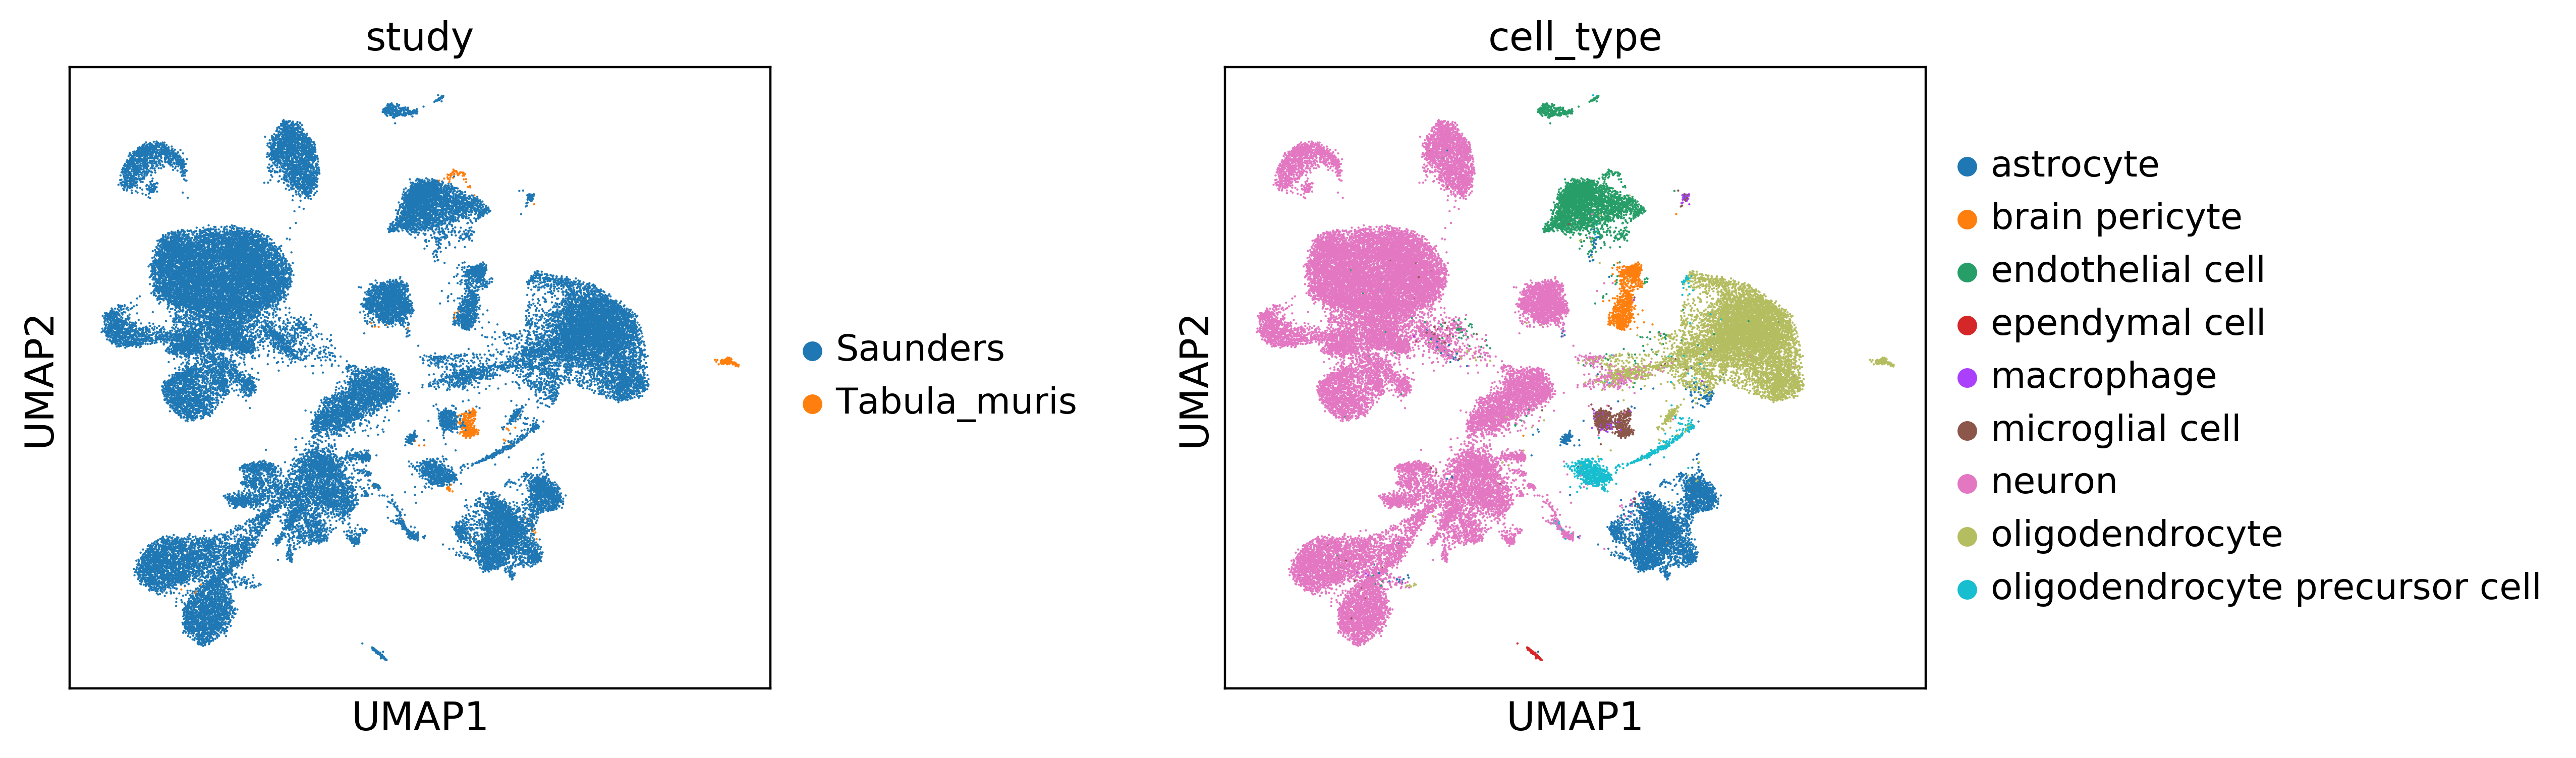

In [20]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [21]:
surgeon.metrics.ari(latent_adata, cell_type_key)

0.3409871808995458

In [ ]:
%load_ext rpy2.ipython

In [ ]:
umap = latent_adata.obsm['X_umap']
batch = latent_adata.obs[condition_key]

In [ ]:
%%R -i umap -i batch -o vals

library(kBET)

batch.estimate <- kBET(umap, batch, do.pca=FALSE)
vals = batch.estimate[['summary']][2:4,2]

# Perfroming architecture Surgery

In [22]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              init='Xavier',
                              freeze=True)

/home/mohsen/scnet/surgeon/models/_cvae.py:155: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2004)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 128)          256512      concatenate_3[0][0]              
__________

In [23]:
new_network.condition_encoder

{'Tabula_muris': 0, 'Saunders': 1, 'Rosenberg': 2, 'Zeisel': 3}

## Train with small new dataset containing out-of-sample condition

In [24]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [25]:
train_adata.shape, valid_adata.shape

((16622, 2000), (2934, 2000))

In [26]:
new_network.model_path = "models/CVAE/MouseBrain/After/"

In [27]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=10000,
                  batch_size=64, 
                  early_stop_limit=50,
                  lr_reducer=40, 
                  n_per_epoch=0,
                  save=True, 
                  retrain=True,
                  verbose=2)

Train on 16622 samples, validate on 2934 samples
Epoch 1/10000
 - 1s - loss: 71146.4202 - nb: 71146.4202 - val_loss: 61123.5067 - val_nb: 61123.5067
Epoch 2/10000
 - 1s - loss: 57921.7430 - nb: 57921.7430 - val_loss: 74483.8812 - val_nb: 74483.8812
Epoch 3/10000
 - 1s - loss: 55426.2584 - nb: 55426.2583 - val_loss: 70700.5301 - val_nb: 70700.5301
Epoch 4/10000
 - 1s - loss: 55034.7832 - nb: 55034.7832 - val_loss: 62017.6448 - val_nb: 62017.6448
Epoch 5/10000
 - 1s - loss: 54343.1416 - nb: 54343.1416 - val_loss: 59243.9595 - val_nb: 59243.9595
Epoch 6/10000
 - 1s - loss: 53679.2463 - nb: 53679.2464 - val_loss: 57399.1289 - val_nb: 57399.1289
Epoch 7/10000
 - 1s - loss: 53744.9217 - nb: 53744.9217 - val_loss: 57339.6002 - val_nb: 57339.6002
Epoch 8/10000
 - 1s - loss: 53441.2052 - nb: 53441.2052 - val_loss: 55970.0589 - val_nb: 55970.0589
Epoch 9/10000
 - 1s - loss: 53840.7280 - nb: 53840.7279 - val_loss: 55190.6024 - val_nb: 55190.6024
Epoch 10/10000
 - 1s - loss: 53513.9255 - nb: 53513

In [28]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)
encoder_labels.shape

(19556, 1)

In [29]:
latent_adata = new_network.to_latent(adata_out_of_sample, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 19556 × 20 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster', 'n_counts', 'size_factors'

In [30]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

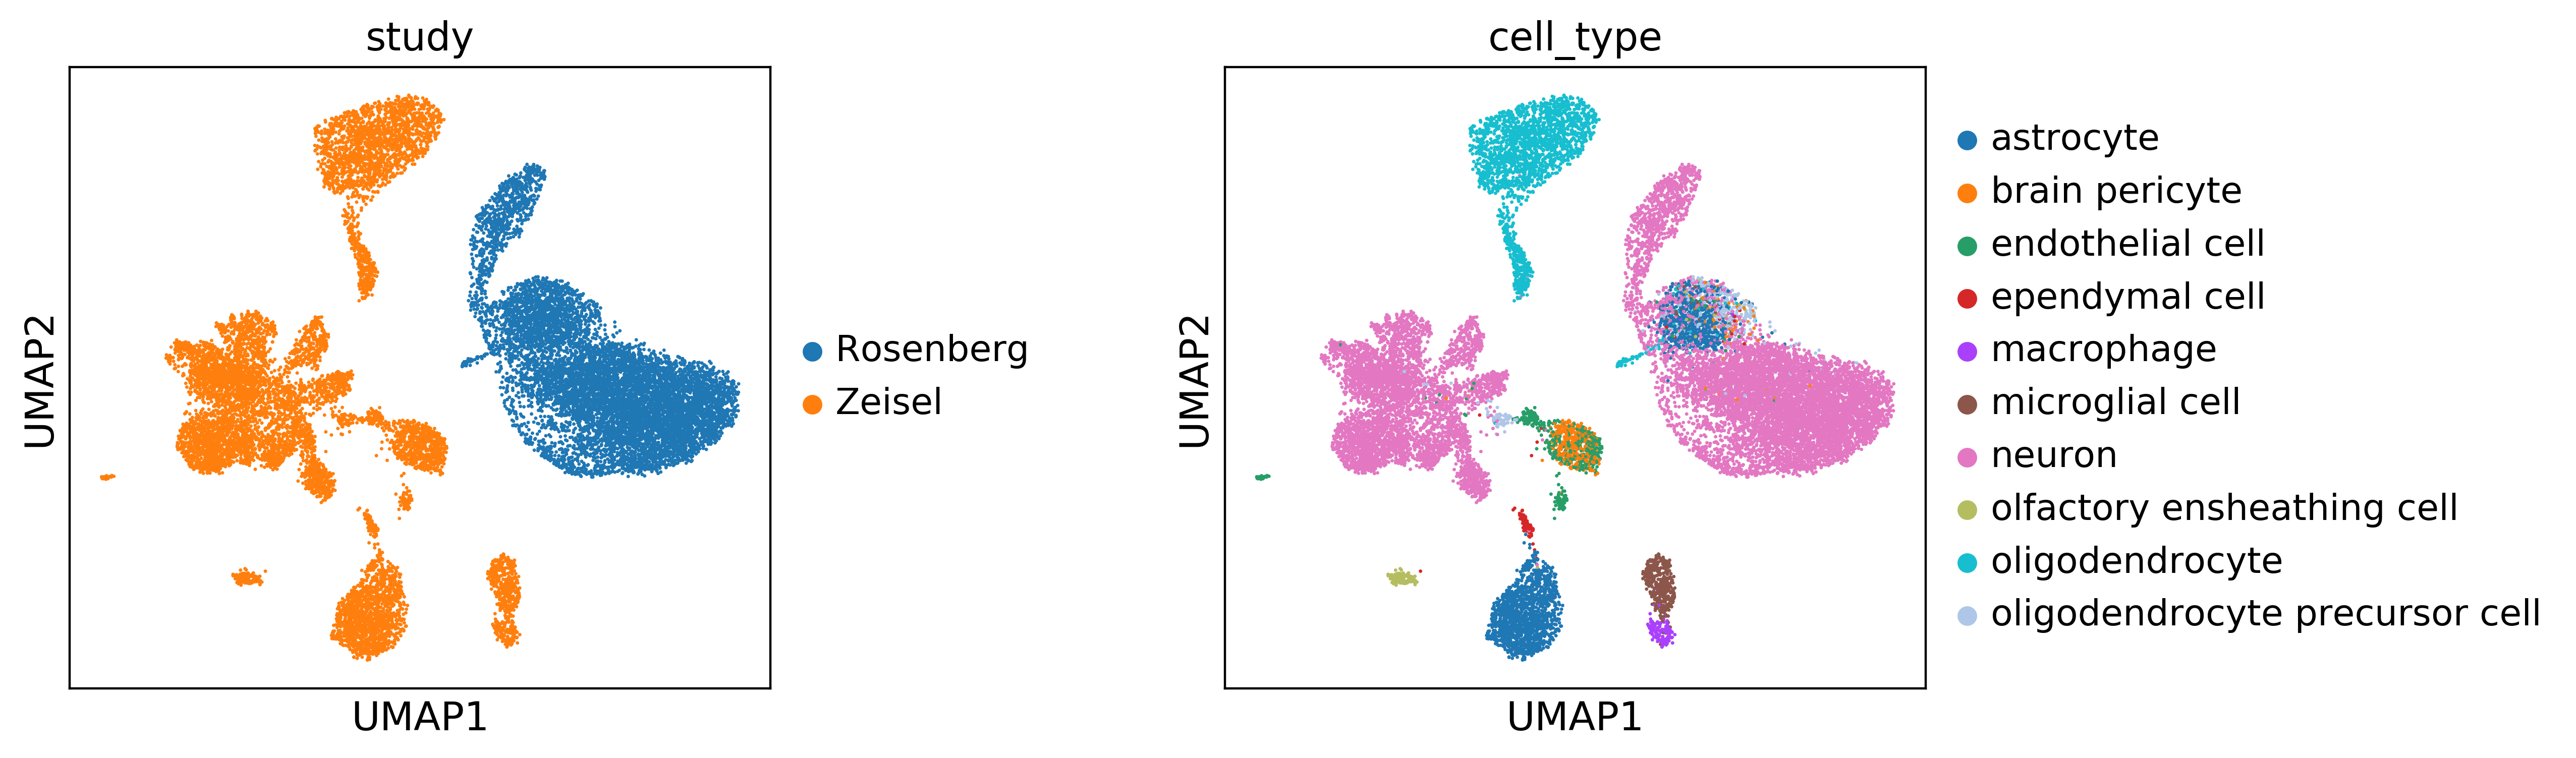

In [31]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [32]:
surgeon.metrics.ari(latent_adata, cell_type_key)

0.2737540400556737

In [ ]:
surgeon.metrics.nmi(latent_adata, cell_type_key)

In [37]:
surgeon.metrics.asw(latent_adata, condition_key)

0.02589478